In [161]:
import numpy as np
import pandas as pd
import json
import os

In [162]:
files = [os.path.join("tables", item) for item in os.listdir("tables") if item.endswith(".json")]
table_headings = [
    "variable",
    "units",
    "baseline-no-ML",
    "temperature-moisture-RF",
    "temperature-moisture-winds-RF",
    "temperature-moisture-winds-prescribed-sfc-RF",
    "temperature-moisture-winds-prescribed-sfc-NN-ensemble",
    "temperature-moisture-prescribed-sfc-RF",
    "temperature-moisture-prescribed-sfc-NN-ensemble",
]


ablation_data = []
for file in files:
    with open(file, "r") as f:
        data = json.load(f)
    if isinstance(data, dict):
        data = [data]
    for entry in data:
        variable_data = []
        
        for column in table_headings:
            variable_data.append(entry[column])
        ablation_data.append(variable_data)


In [163]:
df = pd.DataFrame(ablation_data, columns=table_headings)
df

,variable,units,baseline-no-ML,temperature-moisture-RF,temperature-moisture-winds-RF,temperature-moisture-winds-prescribed-sfc-RF,temperature-moisture-winds-prescribed-sfc-NN-ensemble,temperature-moisture-prescribed-sfc-RF,temperature-moisture-prescribed-sfc-NN-ensemble
0,TMP200_rmse,K,3.030714,2.965507,5.320917,5.341253,3.854490,2.854675,2.730214
1,h500_rms_global_day5_ic_mean,m,46.237999,44.717102,38.514500,38.415798,39.128933,45.025906,44.601345
2,h500_rms_global_day5_ic_std,m,1.105842,1.112559,2.390691,2.373155,1.027262,1.029212,0.839910
3,tmp850_rms_global_day5_ic_mean,K,2.418745,2.199517,2.213602,2.143891,2.040491,2.126498,2.064280
4,tmp850_rms_global_day5_ic_std,K,0.081934,0.068285,0.082298,0.060540,0.047414,0.060621,0.058184
5,tmp200_rms_global_day5_ic_mean,K,2.397740,2.135306,2.863967,2.900081,2.434881,2.134798,2.137587
6,tmp200_rms_global_day5_ic_std,K,0.073854,0.057906,0.258688,0.265248,0.161817,0.062779,0.086025
7,global_surface_precipitation_rmse,mm/day,3.655571,2.659678,2.722468,2.568616,2.527530,2.538595,2.556271
8,land_surface_precipitation_bias,mm/day,1.093459,0.796128,0.937544,0.359086,0.002964,0.115097,0.036406


In [164]:
ax.__dict__

{'figure': <Figure size 1152x216 with 6 Axes>,
 '_subplotspec': <matplotlib.gridspec.SubplotSpec at 0x7f8d2fad0610>,
 'figbox': Bbox([[0.8144835069444446, 0.19351851851851853], [0.9891302232998085, 0.8851851851851852]]),
 'numRows': 1,
 'numCols': 5,
 '_stale': True,
 'stale_callback': <function matplotlib.figure._stale_figure_callback(self, val)>,
 '_axes': <matplotlib.axes._subplots.AxesSubplot at 0x7f8d2fad0110>,
 '_transform': None,
 '_transformSet': False,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': None,
 '_clippath': None,
 '_clipon': True,
 '_label': '',
 '_picker': None,
 '_contains': None,
 '_rasterized': None,
 '_agg_filter': None,
 '_mouseover': False,
 'eventson': False,
 '_oid': 0,
 '_propobservers': {},
 '_remove_method': <bound method Figure._remove_ax of <Figure size 1152x216 with 6 Axes>>,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': [],
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 '_positio

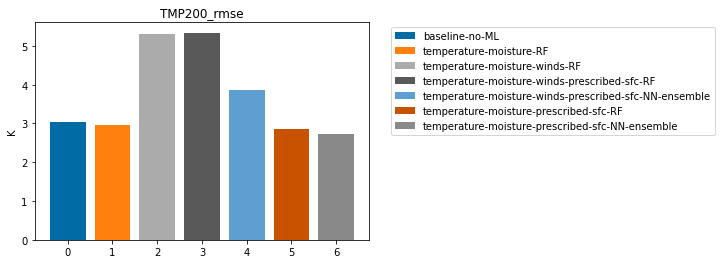

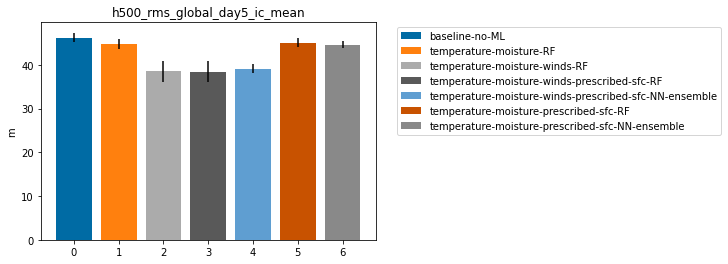

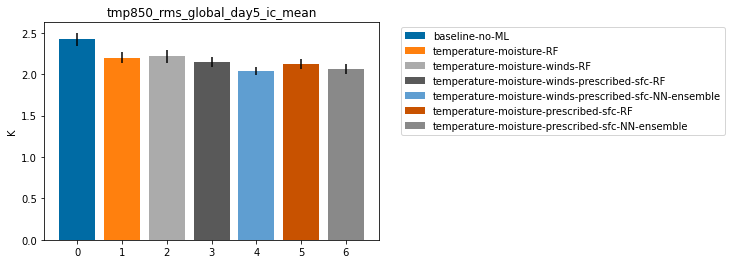

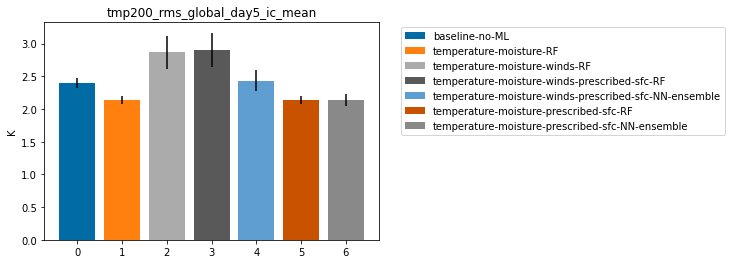

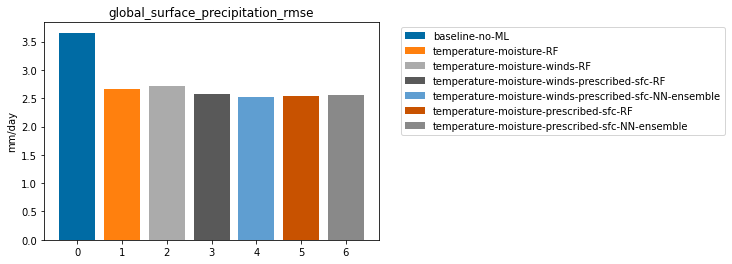

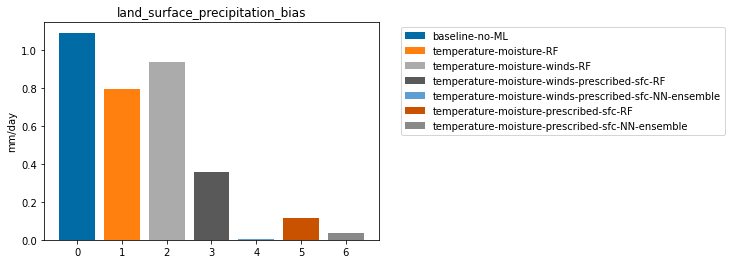

In [165]:
import matplotlib.pyplot as plt

for variable in df["variable"].values:
    if variable.endswith("std"):
        continue

    row = df.loc[ df["variable"] == variable].values[0]
    y = row[2:]
    title = row[0]
    labels = df.columns[2:].values
    units = row[1]

    if variable.endswith("mean"):
        for i in range(len(y)):
            std = df.loc[ df["variable"] == variable.replace("mean", "std")].values[0][2:]
            plt.bar([i,], [y[i],] , yerr=std[i], label=labels[i])

    else:
        for i in range(len(y)):
            plt.bar([i,], [y[i],], label=labels[i])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel(units)
    #plt.xaxis().set_visible(False)
    plt.title(title)
    plt.show()

#### Can copy/paste this output into the latex document.

In [166]:

print(
    df.to_latex(
        index=False, 
        float_format="{:0.2f}".format,
    )
)

\begin{tabular}{llrrrrrrr}
\toprule
                          variable &   units &  baseline-no-ML &  temperature-moisture-RF &  temperature-moisture-winds-RF &  temperature-moisture-winds-prescribed-sfc-RF &  temperature-moisture-winds-prescribed-sfc-NN-ensemble &  temperature-moisture-prescribed-sfc-RF &  temperature-moisture-prescribed-sfc-NN-ensemble \\
\midrule
                       TMP200\_rmse &       K &            3.03 &                     2.97 &                           5.32 &                                          5.34 &                                               3.85 &                                    2.85 &                                             2.73 \\
      h500\_rms\_global\_day5\_ic\_mean &       m &           46.24 &                    44.72 &                          38.51 &                                         38.42 &                                              39.13 &                                   45.03 &                                      

#### effect of wind tendencies (compare 2-3) on the upper atmosphere air temperature bias

In [156]:
import fsspec
import xarray as xr

def plot_zonal_pressure_bias(diags, diags_baseline, var, **plot_kwargs):
    fig = plt.figure()
    ds = xr.concat(
        [diags_baseline[[var]]] + [diags[experiment][[var]] for experiment in diags] ,
        dim=pd.Index(["baseline"] + [f"{tau} hr" for tau in diags.keys()], name="timescale")
    )

    return ds[var].plot(
        x="latitude",
        yincrease=False,
        col="timescale",
        **plot_kwargs
    )
    return fig

In [157]:
experiments = [
    "temperature-moisture-RF",
    "temperature-moisture-winds-RF",
    "temperature-moisture-winds-prescribed-sfc-RF",
    "temperature-moisture-winds-prescribed-sfc-NN-ensemble"
]

prog_run_paths = [
    "gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/control-dq1-dq2-rf/initial_conditions_runs/20160805.000000",
    "gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/control-rf/prognostic_run_tendencies_only_ics/20160805.000000",
    "gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/initial_conditions_runs/20160805.000000",
    "gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/initial_conditions_runs_rectified_nn_rad/20160805.000000"
]
paths = [f"gs://vcm-ml-public/argo/prog-report-nudge-to-3km-ablation-runs/{exp}" for exp in experiments]


with fsspec.open("gs://vcm-ml-public/argo/2021-05-04-nudge-to-c3072-prog-timescales/physics-on-baseline/diags.nc", "rb") as f:
    diags_baseline = xr.open_dataset(f).load()
    
    
diags = {}
for experiment, path in zip(experiments , paths):
    print(path)
    with fsspec.open(f"{path}/diags.nc", "rb") as f:
        diags[experiment] = xr.open_dataset(f).load()

gs://vcm-ml-public/argo/prog-report-nudge-to-3km-ablation-runs/temperature-moisture-RF
gs://vcm-ml-public/argo/prog-report-nudge-to-3km-ablation-runs/temperature-moisture-winds-RF
gs://vcm-ml-public/argo/prog-report-nudge-to-3km-ablation-runs/temperature-moisture-winds-prescribed-sfc-RF
gs://vcm-ml-public/argo/prog-report-nudge-to-3km-ablation-runs/temperature-moisture-winds-prescribed-sfc-NN-ensemble


Text(95.375, 0.5, 'Pressure [Pa]')

<Figure size 432x288 with 0 Axes>

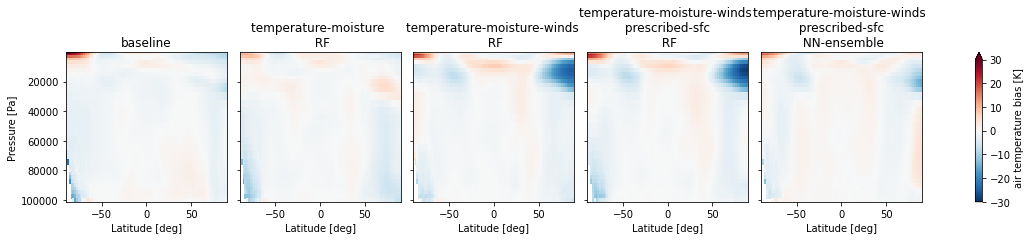

In [160]:
fig = plot_zonal_pressure_bias(diags, diags_baseline, "air_temperature_pressure_level_zonal_bias", vmax=30)
fig.cbar.set_label("air temperature bias [K]")

# plot function puts baseline first
labels = [
    "baseline",
    "temperature-moisture \n RF",
    "temperature-moisture-winds \n RF",
    "temperature-moisture-winds \n prescribed-sfc \n RF",
    "temperature-moisture-winds \n prescribed-sfc \n NN-ensemble"
]
for ax, label in zip(fig.axes[0], labels):
    ax.set_xlabel("Latitude [deg]")
    ax.set_title(label)
fig.axes[0][0].set_ylabel("Pressure [Pa]")